Imports

In [1]:
!gdown 1N9EOJWsbAAiGHaUuEPDHybX9Y1YG976h
!pip install -U sentence-transformers
!pip install adjustText
import pandas as pd
import torch
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.tree import maximum_spanning_tree
from sentence_transformers import SentenceTransformer, util
from adjustText import adjust_text
df = pd.read_excel('assaltos.xlsx', usecols=['descricao', 'municipio'])

Downloading...
From: https://drive.google.com/uc?id=1N9EOJWsbAAiGHaUuEPDHybX9Y1YG976h
To: /content/assaltos.xlsx
100% 561k/561k [00:00<00:00, 145MB/s]




---

Coletando a cidade, estado e descrição de cada registro

In [2]:
df[['cidade','estado','pais']] = (
    df['municipio'].str.split(',', expand=True)
)

descrições = df['descricao'].tolist()
cidades = df['cidade'].tolist()
estados = df['estado'].tolist()


print(len(descrições))
print(len(cidades))
print(len(estados))
print(descrições[0])
print(cidades[0])
print(estados[0])

15636
15636
15636
Moradores do Ipiranga, na Zona Sul, sofrem com três dias consecutivos de assaltos no bairro: 'Minuto mais longo da minha vida' - G1
São Paulo
 SP




---

Geração das embeddings apartir das descrições, e suas similaridades


In [3]:
model = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")
embeddings = model.encode(descrições, convert_to_tensor= True, normalize_embeddings=True)
print(embeddings)

similaridade = model.similarity(embeddings, embeddings)
print(similaridade.shape)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tensor([[ 0.0142,  0.0178, -0.0060,  ...,  0.0349, -0.0227,  0.0124],
        [-0.0151, -0.0409, -0.0050,  ...,  0.0314,  0.0130,  0.0041],
        [-0.0587,  0.0797, -0.0081,  ...,  0.0323,  0.0319,  0.0103],
        ...,
        [-0.0305,  0.0719, -0.0053,  ...,  0.0148, -0.0144,  0.0555],
        [-0.0341,  0.0383, -0.0048,  ..., -0.0140,  0.0145,  0.0065],
        [-0.0340,  0.0117, -0.0035,  ...,  0.0231,  0.0030,  0.0019]],
       device='cuda:0')
torch.Size([15636, 15636])




---

Com as embeddings foi calculado a similaridade entre cosenos (o quão parecida é a descrição dos crimes em cada cidade) representado pela sim_matrix

In [4]:
df = df.reset_index(drop=True)
embeddings = embeddings.cpu()
df['emb'] = list(embeddings)

emb_cidade = df.groupby('cidade')['emb'].apply(lambda x: torch.stack(x.tolist()).mean(dim=0))
cidades = emb_cidade.index.tolist()
cidade_tensor = torch.stack(emb_cidade.values.tolist())
sim_matrix = util.cos_sim(cidade_tensor, cidade_tensor).cpu().numpy()
print(sim_matrix)

[[0.99999976 0.83694667 0.84029424 ... 0.7901299  0.8023399  0.7635381 ]
 [0.83694667 1.0000001  0.8716957  ... 0.8242141  0.8544425  0.80449665]
 [0.84029424 0.8716957  1.0000001  ... 0.88835007 0.88138366 0.8233832 ]
 ...
 [0.79012984 0.82421416 0.88835025 ... 0.9999999  0.88874406 0.8086632 ]
 [0.8023399  0.8544424  0.8813837  ... 0.888744   0.9999999  0.82778615]
 [0.7635382  0.8044968  0.82338315 ... 0.80866325 0.82778615 1.0000001 ]]




---
Cria um grafo para representar as cidades como nos, e suas similaridades (acima de 95% ) sendo as arestas do grafo.
O grafo deve ser conexo, então é forçado a ser pela MTS.
Tambem se calcula o matriz de adjacência binária e ponderada.


In [5]:
import numpy as np
n = len(cidades)
threshold = 0.95
G = nx.Graph()
G.add_nodes_from(cidades)
for i in range(n):
    for j in range(i+1, n):
         w = sim_matrix[i, j]
         if w >= threshold:
            G.add_edge(cidades[i], cidades[j], weight=w)



if not nx.is_connected(G): #força a ser conexo
    full = nx.Graph()
    full.add_nodes_from(cidades)
    for i in range(n):
        for j in range(i+1, n):
            full.add_edge(cidades[i], cidades[j], weight=sim_matrix[i, j])
    mst_full = maximum_spanning_tree(full, weight='weight')
    for u, v, d in mst_full.edges(data=True):
        if not G.has_edge(u, v):
            G.add_edge(u, v, weight=d['weight'])


graus = dict(G.degree())
print("Graus:", list(graus.items())[:10])

# Matriz binária (0/1)
A_bin = nx.to_numpy_array(G, nodelist=cidades, dtype=int)
print("Adjacência binária (0/1):\n", A_bin)

# Matriz ponderada
A_w = nx.to_numpy_array(G, nodelist=cidades, weight='weight')
print("Adjacência ponderada:\n", A_w)

Graus: [('Abaetetuba', 1), ('Alagoinhas', 3), ('Almirante Tamandaré', 1), ('Altamira', 3), ('Alvorada', 5), ('Americana', 2), ('Ananindeua', 1), ('Angra dos Reis', 2), ('Anápolis', 1), ('Aparecida de Goiânia', 3)]
Adjacência binária (0/1):
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Adjacência ponderada:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]




---
Foi necessário debug para confirmar se A_w tinha sido corretamente montada.


In [6]:
print("\n===== Debug: Conteúdo de A_w =====")
for i in range(10):
    print(f"{cidades[i]:20s}: soma = {A_w[i].sum():.6f}, valores iniciais = {A_w[i, :5]}")


===== Debug: Conteúdo de A_w =====
Abaetetuba          : soma = 0.891131, valores iniciais = [0. 0. 0. 0. 0.]
Alagoinhas          : soma = 2.786240, valores iniciais = [0. 0. 0. 0. 0.]
Almirante Tamandaré : soma = 0.936987, valores iniciais = [0. 0. 0. 0. 0.]
Altamira            : soma = 2.789534, valores iniciais = [0.         0.         0.         0.         0.93302441]
Alvorada            : soma = 4.573146, valores iniciais = [0.         0.         0.         0.93302441 0.        ]
Americana           : soma = 1.839306, valores iniciais = [0. 0. 0. 0. 0.]
Ananindeua          : soma = 0.907158, valores iniciais = [0. 0. 0. 0. 0.]
Angra dos Reis      : soma = 1.781006, valores iniciais = [0. 0. 0. 0. 0.]
Anápolis            : soma = 0.915367, valores iniciais = [0. 0. 0. 0. 0.]
Aparecida de Goiânia: soma = 2.780707, valores iniciais = [0. 0. 0. 0. 0.]




---
Debug para ver se o grafo G refletia a matriz de adjacência.


In [33]:
idx = {cidade: i for i, cidade in enumerate(cidades)}
errors = []

for u, v, d in G.edges(data=True):
    i, j = idx[u], idx[v]
    w_graph = d['weight']
    w_mat   = A_w[i, j]
    if not np.isclose(w_graph, w_mat):
        errors.append((u, v, w_graph, w_mat))

for i in range(n):
    for j in range(n):
        if i == j:
            continue
        u, v = cidades[i], cidades[j]
        if not G.has_edge(u, v):
            if not np.isclose(A_w[i, j], 0.0):
                errors.append((u, v, None, A_w[i, j]))
if not errors:
    print("Todos os pesos batem: A_w reflete exatamente as arestas de G.")
else:
    print(f"Encontrados {len(errors)} inconsistências:")
    for e in errors[:10]:  # mostra até 10 para não poluir a saída
        u, v, wg, wm = e
        if wg is None:
            print(f"  - Não-aresta {u}-{v}: A_w={wm:.4f} (esperava 0)")
        else:
            print(f"  - Aresta {u}-{v}: G.weight={wg:.4f} vs A_w={wm:.4f}")
    if len(errors) > 10:
        print(f"  ... e mais {len(errors)-10} erros não mostrados.")


Todos os pesos batem: A_w reflete exatamente as arestas de G.




---
Visualização do grafo G.


Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 384 kB in 3s (132 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pac

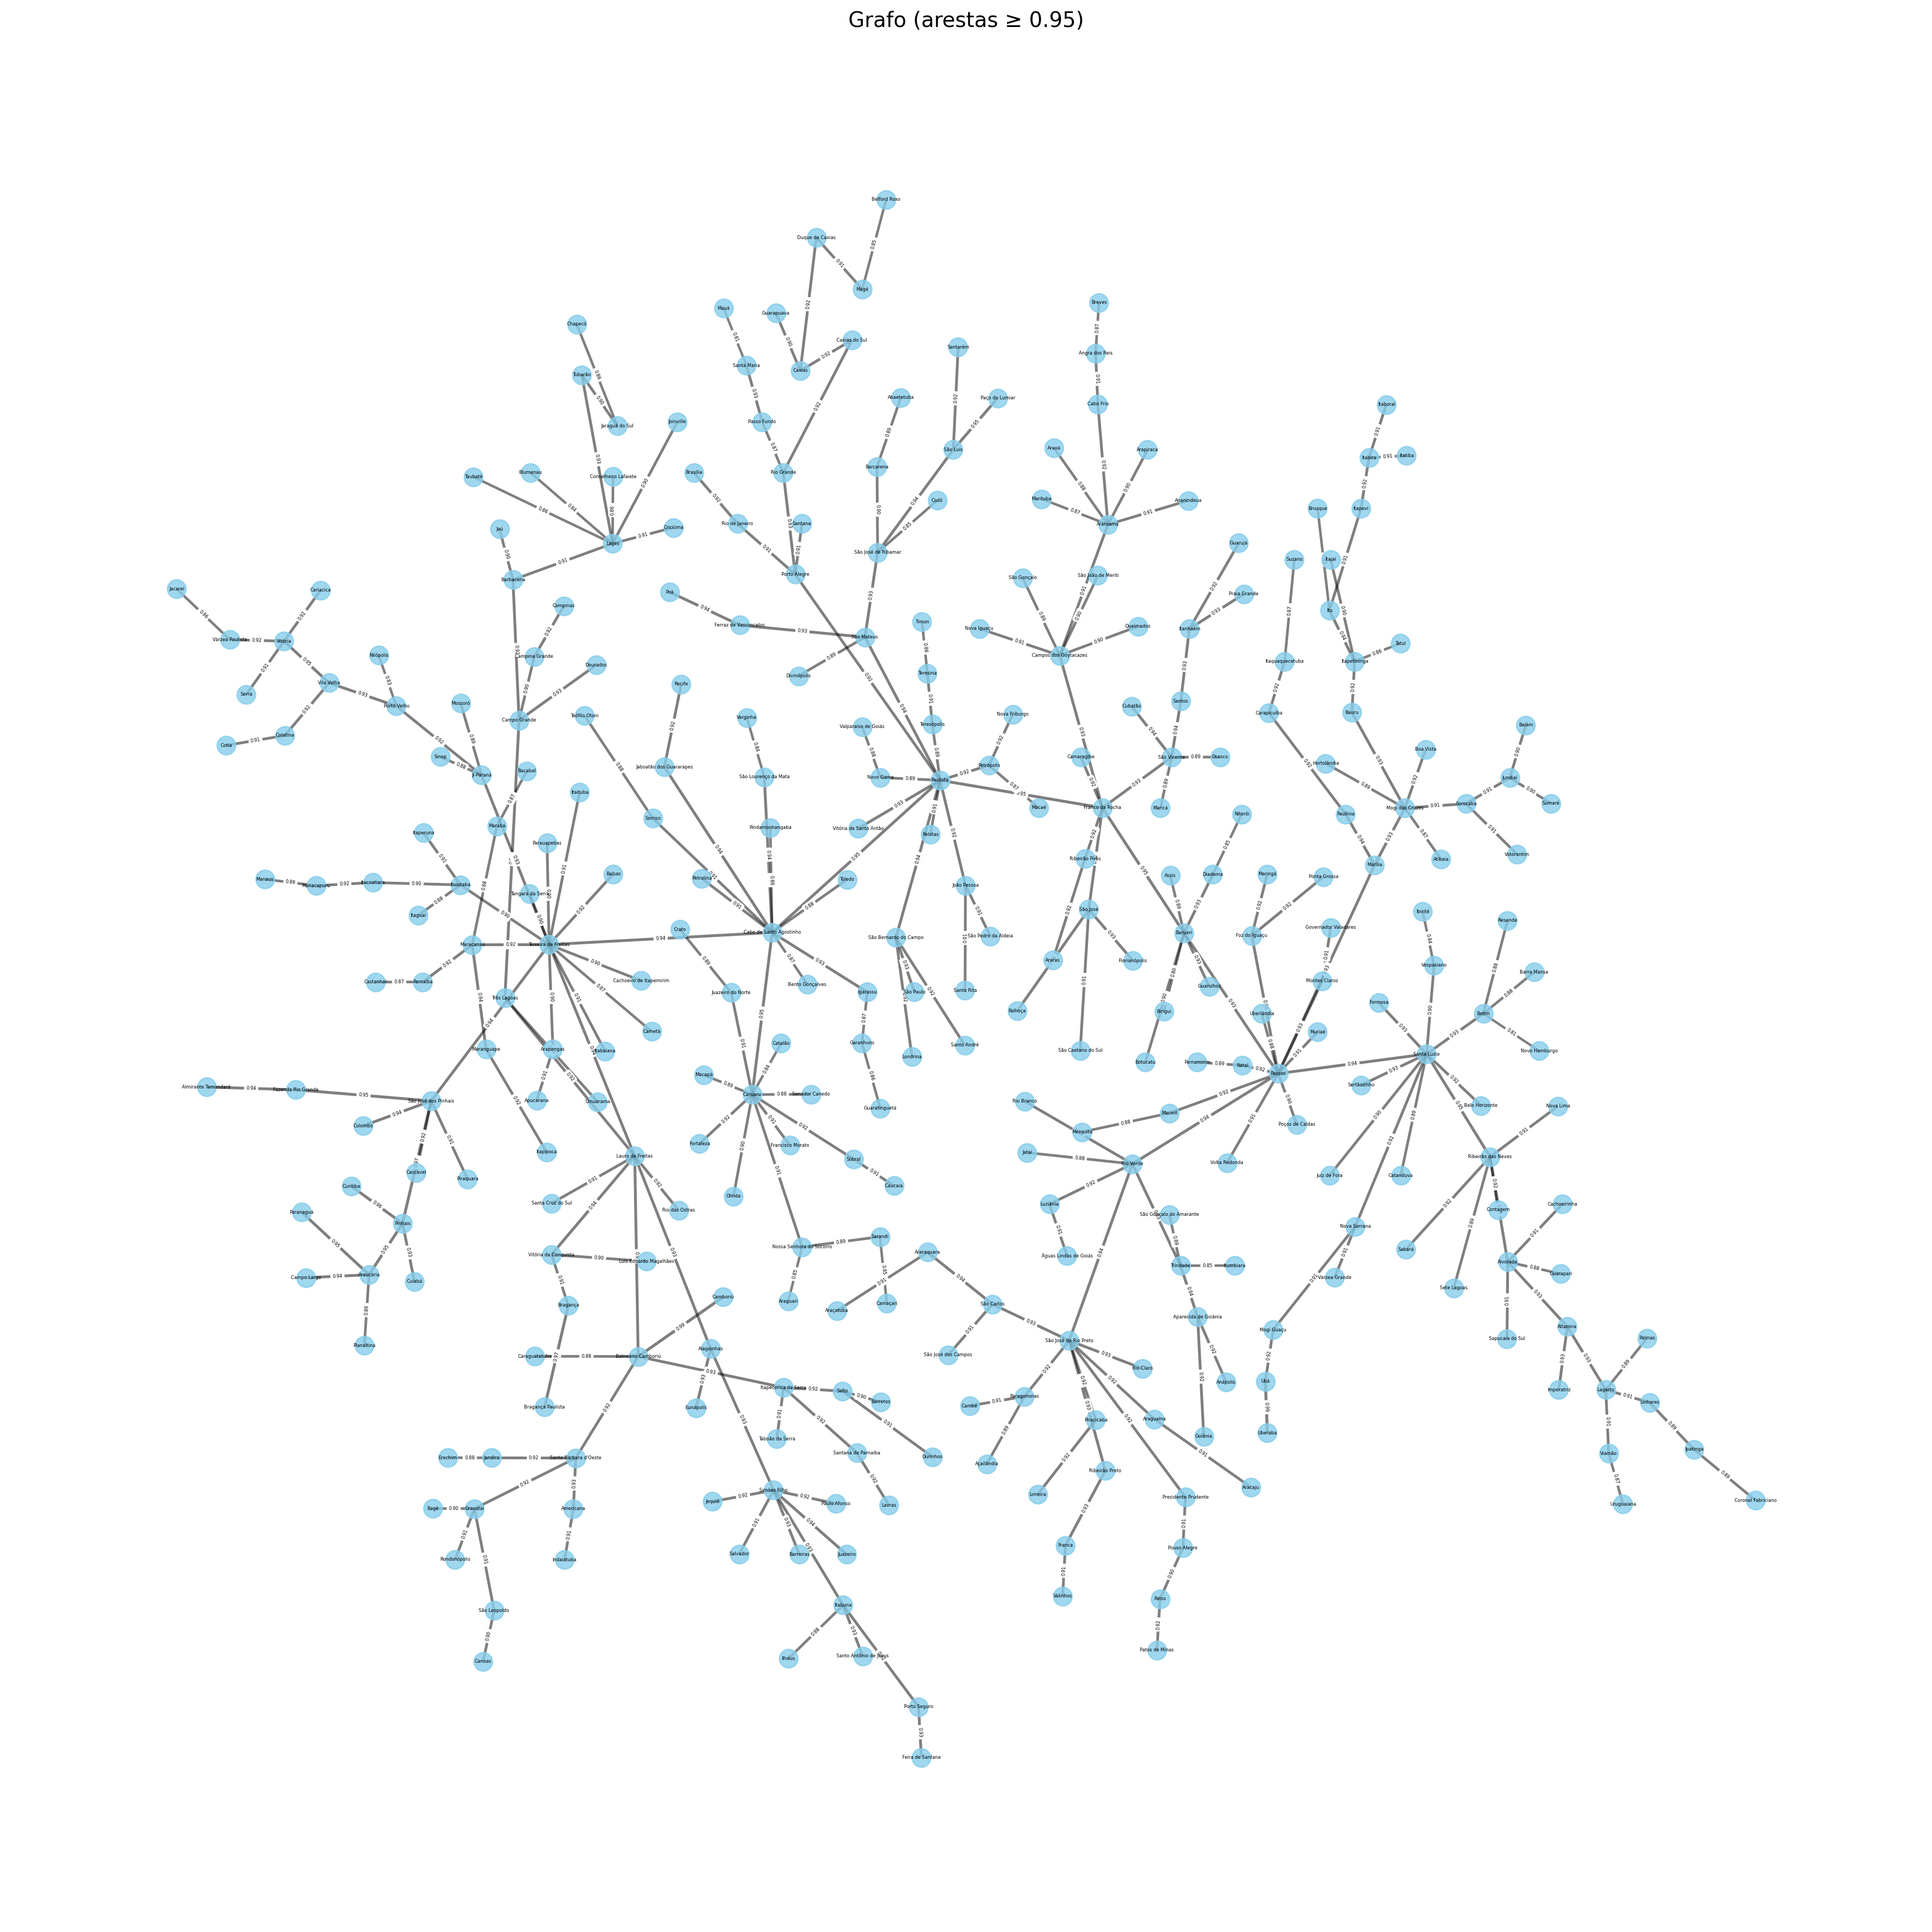

In [8]:
!apt-get update && apt-get install -y graphviz libgraphviz-dev pkg-config
!pip install pygraphviz networkx matplotlib
!pip install pydot graphviz networkx matplotlib
from networkx.drawing.nx_agraph import graphviz_layout

pos = graphviz_layout(G, prog='sfdp', args='-Goverlap=false -Gsep=1')


plt.figure(figsize=(18, 18),dpi = 200)

nx.draw_networkx_nodes(
    G, pos,
    node_size=150,
    node_color='skyblue',
    alpha=0.8
)
nx.draw_networkx_labels(
    G, pos,
    font_size=3,
    font_color='black'
)
nx.draw_networkx_edges(
    G, pos,
    width=[d['weight']*2 for _,_,d in G.edges(data=True)],
    alpha=0.5
)
edge_labels = {
    (u, v): f"{d['weight']:.2f}"
    for u, v, d in G.edges(data=True)
}
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_size=3,
    label_pos=0.5
)
plt.title(f"Grafo (arestas ≥ {threshold:.2f})", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()




---
O grafo G é periódico, oque dificulta a convergencia do Vetor estacionário π.


In [32]:
if nx.is_bipartite(G):
    print("Atenção: O grafo é bipartido → a cadeia de Markov tem período 2 (não aperiódica).")
    periodic = True
else:
    print("O grafo NÃO é bipartido → cadeia presumivelmente aperiódica (período 1).")
    periodic = False

Atenção: O grafo é bipartido → a cadeia de Markov tem período 2 (não aperiódica).


Constrição da matriz de transição estocástica P, porem como o grafo é periódico oque causa a necessidade de transforma-lo em aperiódico

In [29]:
P = np.zeros_like(A_w)

for i in range(n):
    row_sum = A_w[i].sum()
    if row_sum == 0:
        P[i, i] = 1.0
    else:
        P[i, :] = A_w[i, :] / row_sum

print(periodic)
print("\n===== Debug: Conteúdo de P ANTES do teleporte =====")
for i in range(10):
    soma_i = P[i].sum()
    print(f"{cidades[i]:20s}: soma P[{i},:] = {soma_i:.6f}, P[{i},:5] = {P[i, :5]}")


alpha = 1e-4
if periodic:
  print("grafo é periódico")
  P = (1.0 - alpha) * P + alpha * (np.ones((n, n)) / n)
  print("\n===== Debug: P APÓS o teleporte =====")
  linhas_depois = P.sum(axis=1)
  for i in range(10):
      print(f"{cidades[i]:20s}: soma P[{i},:] = {linhas_depois[i]:.6f}, P[{i},:5] = {P[i,:5]}")


linhas_somam = np.allclose(P.sum(axis=1), np.ones(n))
print("Todas as linhas de P somam 1? ", linhas_somam)
print(P)

True

===== Debug: Conteúdo de P ANTES do teleporte =====
Abaetetuba          : soma P[0,:] = 1.000000, P[0,:5] = [0. 0. 0. 0. 0.]
Alagoinhas          : soma P[1,:] = 1.000000, P[1,:5] = [0. 0. 0. 0. 0.]
Almirante Tamandaré : soma P[2,:] = 1.000000, P[2,:5] = [0. 0. 0. 0. 0.]
Altamira            : soma P[3,:] = 1.000000, P[3,:5] = [0.         0.         0.         0.         0.33447319]
Alvorada            : soma P[4,:] = 1.000000, P[4,:5] = [0.         0.         0.         0.20402244 0.        ]
Americana           : soma P[5,:] = 1.000000, P[5,:5] = [0. 0. 0. 0. 0.]
Ananindeua          : soma P[6,:] = 1.000000, P[6,:5] = [0. 0. 0. 0. 0.]
Angra dos Reis      : soma P[7,:] = 1.000000, P[7,:5] = [0. 0. 0. 0. 0.]
Anápolis            : soma P[8,:] = 1.000000, P[8,:5] = [0. 0. 0. 0. 0.]
Aparecida de Goiânia: soma P[9,:] = 1.000000, P[9,:5] = [0. 0. 0. 0. 0.]
grafo é periódico

===== Debug: P APÓS o teleporte =====
Abaetetuba          : soma P[0,:] = 1.000000, P[0,:5] = [3.14465409e-07 3.1



---
Calculo da distribuição estacionária e do Vetor estacionário π pelo metofo Power Method onde foi nescessario grande numero de iterações.


In [31]:
pi = np.ones(n) / n
tol = 1e-8
max_iter = 1000000
convergiu = False

for it in range(max_iter):
    pi_next = np.dot(pi, P)
    diff = np.linalg.norm(pi_next - pi, ord=1)
    if diff < tol:
        convergiu = True
        print(f"Power Method convergiu em {it+1} iterações (L1-diff = {diff:.2e}).")
        break
    pi = pi_next

if not convergiu:
    print(f"Atenção: Power Method NÃO convergiu em {max_iter} iterações (última L1-diff = {diff:.2e}).")
    # COMO FALLBACK, calcule via autovetores do numpy
    print("Calculando vetor estacionário via autovetores do numpy (fallback)…")
    # P.T @ v = 1 * v <=> (transposta) autovetor do autovalor 1
    w, v = np.linalg.eig(P.T)
    idx1 = np.argmin(np.abs(w - 1))
    pi_unnormalized = np.real(v[:, idx1])
    pi = pi_unnormalized / pi_unnormalized.sum()
    pi = np.abs(pi)
    print("Fallback gerou π via autovetor associado ao autovalor 1.")


pi = np.real(pi)
pi = pi / pi.sum()
if np.any(pi < 0):
    raise RuntimeError("Vetor estacionário π contém valores negativos após normalização.")
print("Soma de π (deveria ser 1):", pi.sum())
print(f"Vetor estacionário: {pi}")
print("\n---- Vetor estacionário π (exemplo das 10 primeiras cidades) ----")
for city, prob in zip(cidades[:10], pi[:10]):
    print(f"{city:20s}: {prob:.6f}")


Power Method convergiu em 140443 iterações (L1-diff = 1.00e-08).
Soma de π (deveria ser 1): 1.0
Vetor estacionário: [0.00154515 0.00482945 0.00162431 0.00483705 0.00792903 0.00318876
 0.00157286 0.00308832 0.00158717 0.00482103 0.00158571 0.00156916
 0.0014708  0.00316016 0.00156273 0.00314343 0.00320486 0.00158757
 0.00935563 0.0064491  0.00153436 0.00157239 0.00154314 0.00151395
 0.00154134 0.00150556 0.0015647  0.00802766 0.00159789 0.00474264
 0.00310243 0.00152489 0.00161466 0.00155669 0.01096836 0.00321412
 0.00147583 0.00160131 0.00156256 0.00150323 0.00607424 0.00137842
 0.001465   0.00159414 0.00156353 0.00325294 0.00167771 0.00158821
 0.00150657 0.00147969 0.00317845 0.01746956 0.001581   0.00156523
 0.00159893 0.00147496 0.00170763 0.00158611 0.00151283 0.00315496
 0.00159971 0.00640084 0.00162708 0.00943393 0.00155957 0.00151772
 0.00318607 0.00160025 0.01562771 0.00159529 0.00150195 0.00145922
 0.00154423 0.00158454 0.00474624 0.00317791 0.00149525 0.00147951
 0.00317825 0


---
Calculo do random walk



In [12]:
n = len(cidades)
T = 2000000
visitas = np.zeros(n, dtype = int)
estado_atual = np.random.choice(n)

for t in range(T):
  visitas[estado_atual] += 1
  estado_atual = np.random.choice(n, p=P[estado_atual])


frequencia_empirica = visitas / visitas.sum()

df_frequencia_empirica = pd.DataFrame({
    'Cidade': cidades,
    'Frequência Empírica': frequencia_empirica
})

df_frequencia_empirica = df_frequencia_empirica.sort_values(by='Frequência Empírica', ascending=False).reset_index(drop=True)

print("\n---- Frequência Empírica (exemplo das 10 primeiras cidades) ----")
print(df_frequencia_empirica.head(10).to_string(index=False))



---- Frequência Empírica (exemplo das 10 primeiras cidades) ----
                 Cidade  Frequência Empírica
    Teixeira de Freitas             0.023026
                 Passos             0.018249
Cabo de Santo Agostinho             0.017560
               Paulista             0.017518
                Caruaru             0.016133
            Santa Luzia             0.015078
  São José do Rio Preto             0.013050
       Lauro de Freitas             0.011831
           Simões Filho             0.011504
        Franco da Rocha             0.011149




---
Geração do Dataframe da distribuição estácionaria.





In [13]:
df_pi = pd.DataFrame({
    'Cidade': cidades,
    'Probabilidade': pi
})

df_pi = df_pi.sort_values(by='Probabilidade', ascending=False).reset_index(drop=True)

print("\n---- Probabilidade (exemplo das 10 primeiras cidades) ----")
print(df_pi.head(10).to_string(index=False))


---- Probabilidade (exemplo das 10 primeiras cidades) ----
                 Cidade  Probabilidade
    Teixeira de Freitas       0.022163
                 Passos       0.019150
               Paulista       0.017586
Cabo de Santo Agostinho       0.017470
            Santa Luzia       0.015970
                Caruaru       0.015628
  São José do Rio Preto       0.012828
        Franco da Rocha       0.011318
           Simões Filho       0.011262
       Lauro de Freitas       0.011247




---

Comparação entre os dois metodos apresentados, e comparados plea similaridade entre cossenos

In [14]:
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
df_merge = pd.merge(df_pi, df_frequencia_empirica, on='Cidade', how="inner")
print(df_merge.head(),"\n")

freq = df_merge["Frequência Empírica"].values
prob = df_merge["Probabilidade"].values

cos_sim = cosine_similarity(
    freq.reshape(1, -1),
    prob.reshape(1, -1)
)[0,0]
print("Similaridade entre random walk e distribuição estácionaria = ",cos_sim)


                    Cidade  Probabilidade  Frequência Empírica
0      Teixeira de Freitas       0.022163             0.023026
1                   Passos       0.019150             0.018249
2                 Paulista       0.017586             0.017518
3  Cabo de Santo Agostinho       0.017470             0.017560
4              Santa Luzia       0.015970             0.015078 

Similaridade entre random walk e distribuição estácionaria =  0.999093862639567




---

### Atividade 3 – Descoberta de Padrões Criminais com Propagação de Rótulos



---
Grafo G usado anteriormente


Graph with 318 nodes and 317 edges


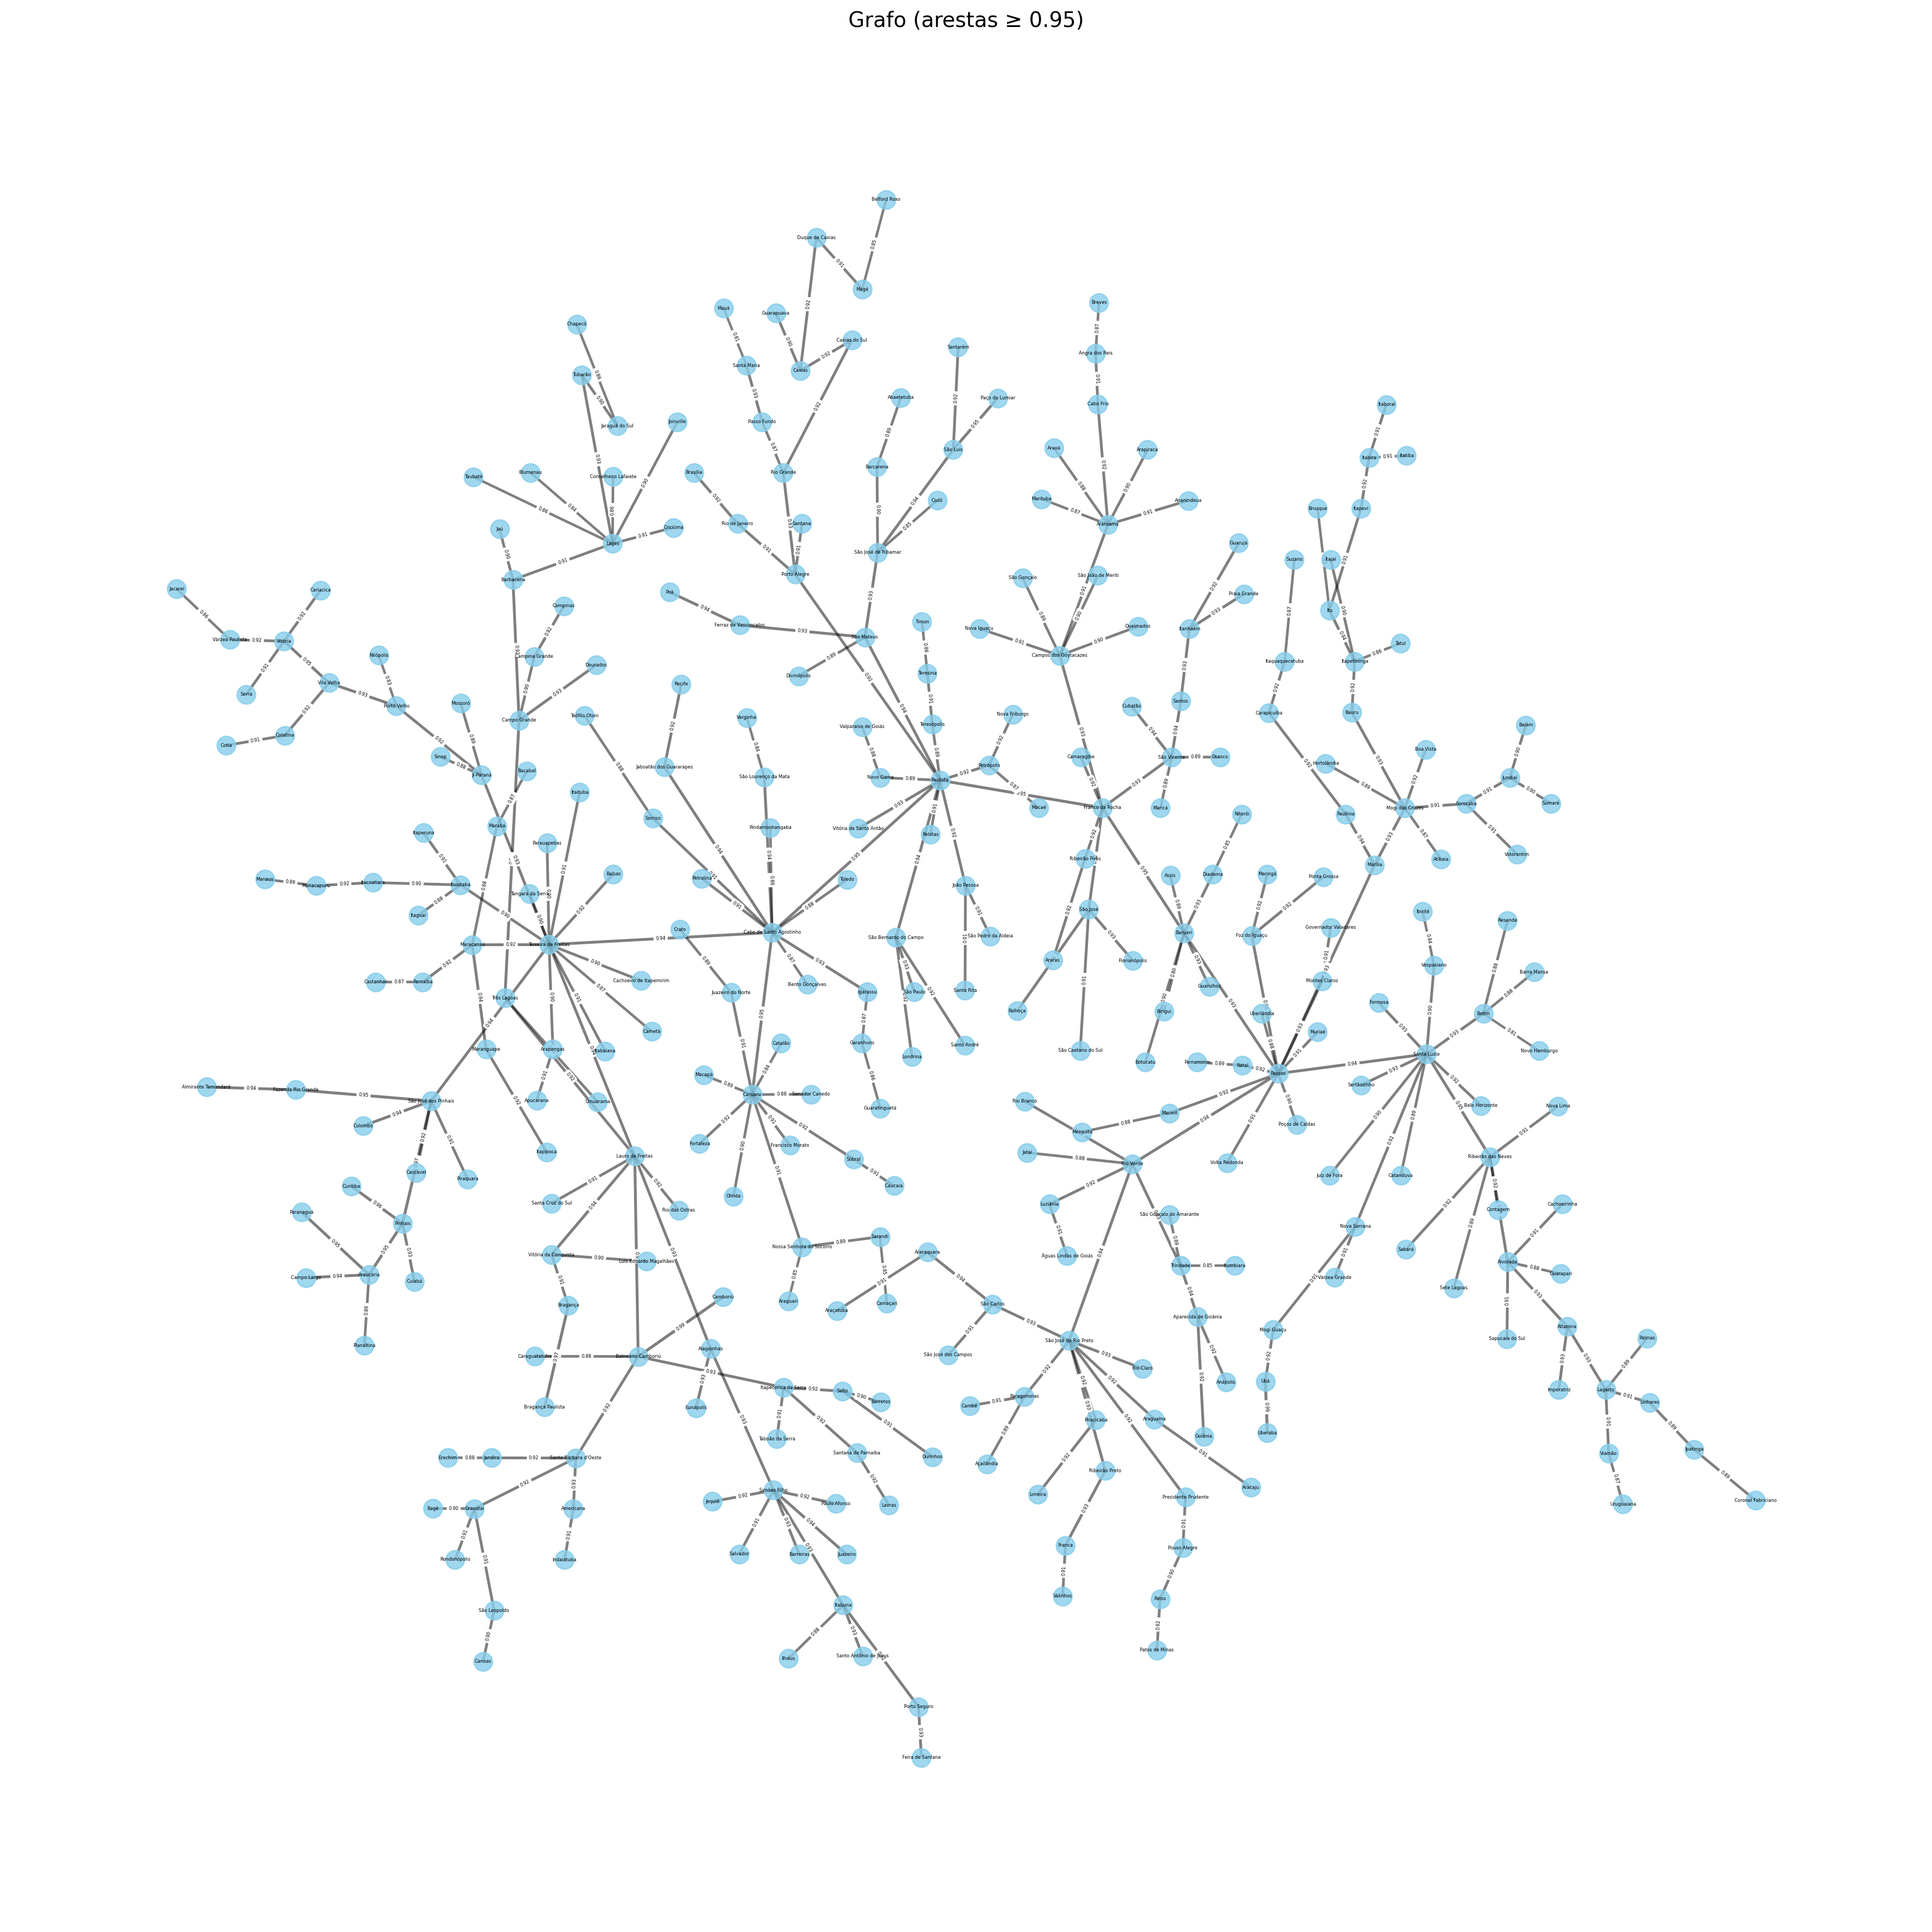

In [15]:
print(G)
pos = graphviz_layout(G, prog='sfdp', args='-Goverlap=false -Gsep=1')
plt.figure(figsize=(18, 18),dpi = 200)
nx.draw_networkx_nodes(
    G, pos,
    node_size=150,
    node_color='skyblue',
    alpha=0.8
)
nx.draw_networkx_labels(
    G, pos,
    font_size=3,
    font_color='black'
)
nx.draw_networkx_edges(
    G, pos,
    width=[d['weight']*2 for _,_,d in G.edges(data=True)],
    alpha=0.5
)
edge_labels = {
    (u, v): f"{d['weight']:.2f}"
    for u, v, d in G.edges(data=True)
}
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_size=3,
    label_pos=0.5
)
plt.title(f"Grafo (arestas ≥ {threshold:.2f})", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()




---

Geração de comunidades usando o Louvain.

In [21]:
import community as community_louvain
from collections import defaultdict


partition = community_louvain.best_partition(G, weight='weight', resolution=0.8)

comunidades = defaultdict(list)
for cidade, grupo in partition.items():
    comunidades[grupo].append(cidade)

print(f"Número de comunidades detectadas: {len(comunidades)}")
for i, membros in enumerate(comunidades.values()):
    print(f"Comunidade {i+1} ({len(membros)} cidades):", sorted(membros)[:5], "...")


Número de comunidades detectadas: 16
Comunidade 1 (29 cidades): ['Abaetetuba', 'Barcarena', 'Codó', 'Divinópolis', 'Ferraz de Vasconcelos'] ...
Comunidade 2 (20 cidades): ['Alagoinhas', 'Barreiras', 'Bragança', 'Bragança Paulista', 'Eunápolis'] ...
Comunidade 3 (13 cidades): ['Almirante Tamandaré', 'Araucária', 'Campo Largo', 'Cascavel', 'Colombo'] ...
Comunidade 4 (18 cidades): ['Altamira', 'Alvorada', 'Cachoeirinha', 'Contagem', 'Coronel Fabriciano'] ...
Comunidade 5 (20 cidades): ['Americana', 'Bagé', 'Balneário Camboriú', 'Barretos', 'Camboriú'] ...
Comunidade 6 (13 cidades): ['Ananindeua', 'Angra dos Reis', 'Arapiraca', 'Araruama', 'Araxá'] ...
Comunidade 7 (25 cidades): ['Anápolis', 'Aparecida de Goiânia', 'Foz do Iguaçu', 'Goiânia', 'Governador Valadares'] ...
Comunidade 8 (23 cidades): ['Apucarana', 'Arapongas', 'Bacabal', 'Balsas', 'Cachoeiro de Itapemirim'] ...
Comunidade 9 (20 cidades): ['Aracaju', 'Araguaína', 'Araraquara', 'Araçatuba', 'Açailândia'] ...
Comunidade 10 (29 c

In [22]:

cidade_to_cluster = partition

df['cluster'] = df['cidade'].map(cidade_to_cluster)

from collections import defaultdict

comunidades = defaultdict(list)
for cidade, cluster_id in partition.items():
    comunidades[cluster_id].append(cidade)

for cluster_id, cidades_cluster in comunidades.items():
    print(f"\n Cluster {cluster_id} - {len(cidades_cluster)} cidades")
    descricoes_exemplo = df[df['cluster'] == cluster_id]['descricao'].sample(min(5, len(cidades_cluster)), random_state=42).tolist()
    for desc in descricoes_exemplo:
        print("-", desc)



 Cluster 12 - 29 cidades
- Tentativa de assalto em Mojuí dos Campos termina com suspeito preso pela PRF - G1
- Polícia prende homem que fingiu ser técnico em refrigeração para cometer assalto a residência, em São Luís - John Cutrim
- Moradora de Valparaíso é esfaqueada durante assalto, bate o carro e morre no DF - ogritonews.com.br
- Reféns de assalto em pedágio voltavam de fim de semana na Baixada; VÍDEO - G1
- Polícia Civil do Pará deflagra Operação Ingratus e prende suspeito de roubo e estupro - Agência Pará de Notícias

 Cluster 1 - 20 cidades
- Idoso é morto a tiros ao buscar pets em clínica veterinária na Bahia - CNN Brasil
- Homem é agredido por passageiros de ônibus e preso após tentar assaltar com arma falsa na Bahia - G1
- Motorista por aplicativo acusado de participar de 8 assaltos na BA é inocentado após mais de dois anos - G1
- PF prende 15 investigados por desvio milionário de recursos públicos na Bahia, em São Paulo e em Goiás - G1
- Quatro foliões ficam feridos após ti



---

Reconhece quais palavras estão mais presentes em cada um dos clusters.

In [23]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

stopwords_pt = stopwords.words('portuguese')

# Obtem os IDs únicos dos clusters (ex: 0, 1, 4, 7, ...)
cluster_ids = df['cluster'].unique()

for cluster_id in cluster_ids:
    descricoes = df[df['cluster'] == cluster_id]['descricao']
    if len(descricoes) >= 3:  # somente clusters com conteúdo suficiente
        vectorizer = TfidfVectorizer(stop_words=stopwords_pt, max_features=10)
        X = vectorizer.fit_transform(descricoes)
        palavras = vectorizer.get_feature_names_out()
        print(f"\n Palavras representativas do Cluster {cluster_id} ({len(descricoes)} descrições):")
        print(", ".join(palavras))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



 Palavras representativas do Cluster 12 (1641 descrições):
após, assalto, durante, g1, homem, polícia, preso, sp, suspeito, vídeo

 Palavras representativas do Cluster 0 (911 descrições):
aeroporto, assalto, brasil, carro, caxias, g1, gzh, polícia, rs, sul

 Palavras representativas do Cluster 5 (1296 descrições):
após, assalto, durante, g1, homem, morto, polícia, preso, suspeito, tiros

 Palavras representativas do Cluster 1 (981 descrições):
após, assalto, bahia, durante, g1, homem, preso, salvador, suspeito, tiros

 Palavras representativas do Cluster 13 (761 descrições):
após, assalto, bh, durante, g1, homem, mg, polícia, roubo, suspeito

 Palavras representativas do Cluster 10 (981 descrições):
após, assalto, br, g1, homem, manaus, polícia, preso, roubo, suspeito

 Palavras representativas do Cluster 2 (632 descrições):
após, assalto, banda, br, curitiba, g1, paraná, polícia, roubo, suspeito

 Palavras representativas do Cluster 11 (1153 descrições):
após, assalto, durante, g1, h



---

Visualização das comunidades no grafo G, separadas por cores.

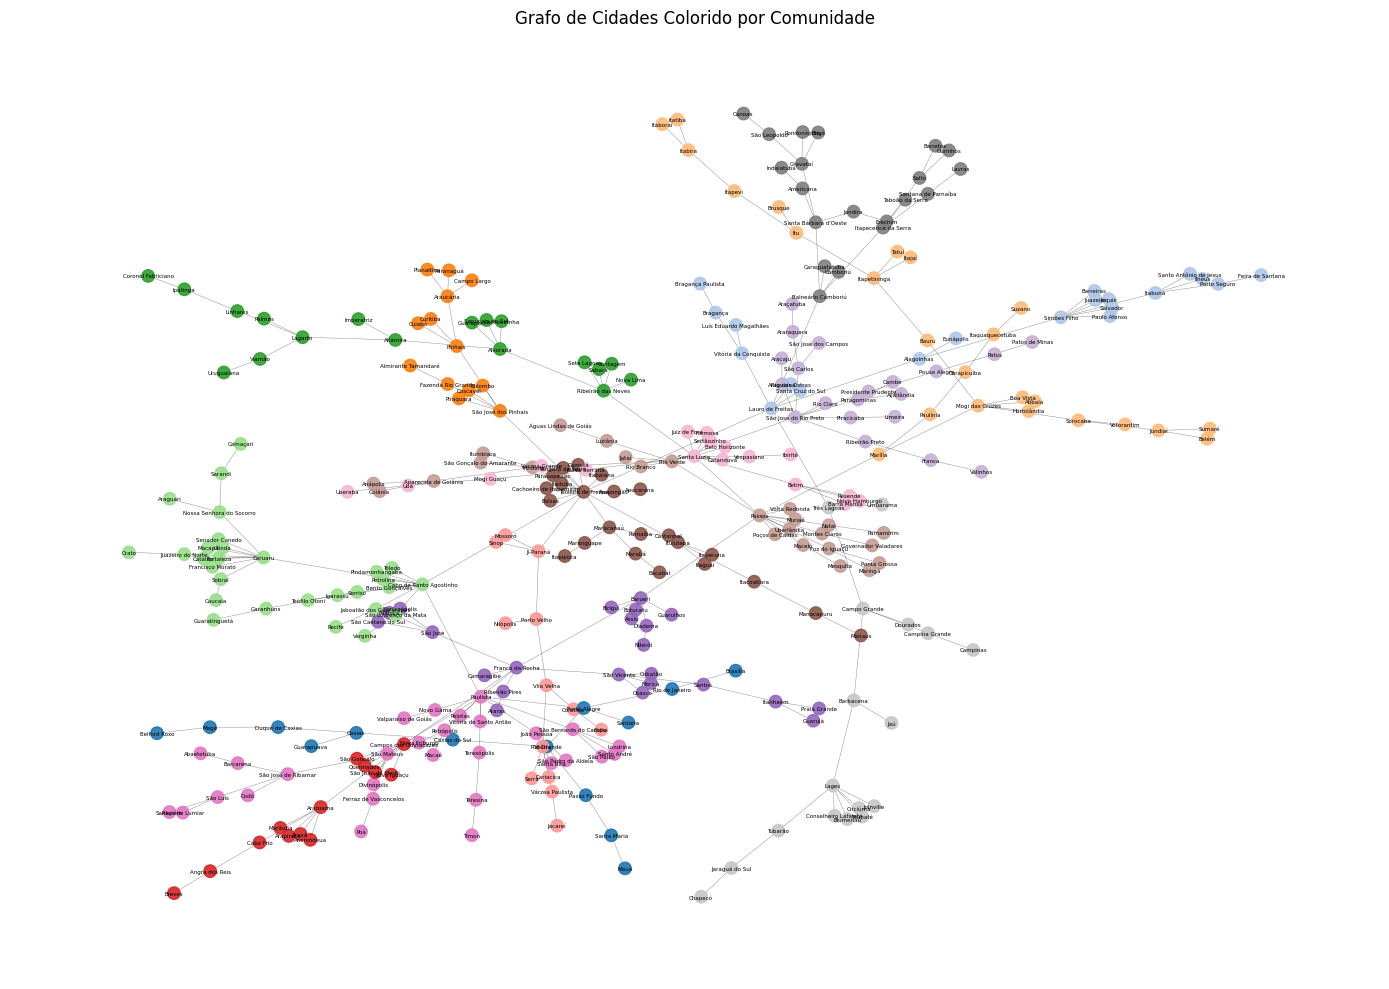

In [24]:
unique_clusters = sorted(set(partition.values()))
cluster_to_color = {cid: plt.cm.tab20(i % 20) for i, cid in enumerate(unique_clusters)}
node_colors = [cluster_to_color[partition[node]] for node in G.nodes]

pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=80, alpha=0.9)
nx.draw_networkx_edges(G, pos, width=0.3, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=4)

plt.title("Grafo de Cidades Colorido por Comunidade")
plt.axis("off")
plt.tight_layout()
plt.show()